# STLinear vs. Hop‑Biased STLinear 비교 실험

이 노트북에서는 다음을 수행합니다:
1. 데이터 로드 및 전처리 (첨부된 `baseline_train_refactoring.ipynb` 참고)
2. STLinear (기존 모델)과 STLinear_HopBiased (홉 기반 어텐션 바이어스 모델)를 정의
3. 32가지 하이퍼파라미터 조합을 미리 생성
4. 16개의 랜덤 시드를 고정한 상태로, 각 조합별로 두 모델을 동일한 데이터로 30 에폭 학습
5. 각각의 학습 과정에서 다음 정보를 기록:
   - 각 에폭의 검증 MAPE 기록 (history)
   - MAPE=1과 MAPE=0.5를 달성한 첫 번째 에폭 (달성 못 하면 None)
   - 30 에폭 동안 달성한 최소 MAPE, 최소 Loss
6. 조합별로 두 모델의 검증 MAPE-에폭 그래프를 그려 비교
7. 실험 종료 후, Hop‑Biased 모델이 얼마나 빠르게 MAPE를 낮췄는지, 최종적으로 얼마나 낮은 MAPE를 달성했는지 요약

In [1]:
# 기본
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED, STGAT
from models.STGCN_with_auxiliary_network_model import STGCNWithAux
from models.STLinear import STLinear
from models.STLinear_deriven import STLinear_HopBiased

c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


In [8]:
# reproducibility 확보
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 128
EPOCHS = 50
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [9]:
# 모델 생성 함수 (하이퍼파라미터를 인자로 받아 초기화)
def make_models(params, distance_hop_tensor):
    """
    params: dict, 하이퍼파라미터 조합 예시
    distance_hop_tensor: torch.LongTensor, shape (E, E)
    반환: (model_base, model_hopbias)
    """
    common_args = {
        'num_nodes': params['num_nodes'],
        'kernel_size': params['kernel_size'],
        'in_steps': params['in_steps'],
        'out_steps': params['out_steps'],
        'input_embedding_dim': params['input_embedding_dim'],
        'tod_embedding_dim': params['tod_embedding_dim'],
        'dow_embedding_dim': params['dow_embedding_dim'],
        'spatial_embedding_dim': params['spatial_embedding_dim'],
        'adaptive_embedding_dim': params['adaptive_embedding_dim'],
        'feed_forward_dim': params['feed_forward_dim'],
        'num_heads': params['num_heads'],  # base 모델도 num_heads 인자는 있지만, 실제로 사용하지 않을 수 있음
        'num_layers': params['num_layers'],
        'dropout': params['dropout'],
        'use_mixed_proj': True,
    }
    # Base STLinear 모델
    model_base = STLinear(**common_args).to(DEVICE)
    # Hop‑Biased 모델
    common_args_hop = common_args.copy()
    common_args_hop['num_heads'] = params['num_heads']  # d_model % num_heads == 0인지 확인 필요
    # distance_hop_tensor은 미리 준비된 (E,E) LongTensor
    model_hop = STLinear_HopBiased(
        **common_args_hop
    ).to(DEVICE)
    return model_base, model_hop


In [10]:
# 3. 하이퍼파라미터 조합 생성 (32가지)
from itertools import product

# 후보 값 정의
param_space = {
    'num_nodes': [50],
    'in_steps': [12],
    'out_steps': [3],
    'kernel_size': [11, 13, 15, 17],
    'input_embedding_dim': [32, 64],
    'tod_embedding_dim': [32, 64],
    'dow_embedding_dim': [32, 64],
    'spatial_embedding_dim': [0, 32],
    'adaptive_embedding_dim': [0, 32],
    'feed_forward_dim': [64, 128],
    'num_heads': [4, 8],           # d_model = input_emb+tod+dow+... = e.g.32+32+32 =96 → 96 % heads ==0? 확인 필요
    'num_layers': [1, 2],
    'dropout': [0.1, 0.2],
}

# 가능한 모든 조합
all_combinations = list(product(*param_space.values()))

# 딕셔너리 목록으로 변환
keys = list(param_space.keys())
param_dicts = [dict(zip(keys, comb)) for comb in all_combinations]

# 32개만 랜덤으로 추출 (혹은 앞 32개)
random.seed(42)
selected_params = random.sample(param_dicts, 32)

print(f"총 조합 수: {len(all_combinations)}, 선택된 실험 조합 수: {len(selected_params)}")

총 조합 수: 2048, 선택된 실험 조합 수: 32


Seed=0, 조합 인덱스=0


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.3651, Valid Loss=1.2830, Train MAPE=1.4578, Valid MAPE=1.0390


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.0279, Valid Loss=1.0238, Train MAPE=1.2262, Valid MAPE=0.7384


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9568, Valid Loss=0.9436, Train MAPE=1.1022, Valid MAPE=0.6900


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.9152, Valid Loss=0.8902, Train MAPE=1.0026, Valid MAPE=0.5931


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8869, Valid Loss=0.8570, Train MAPE=0.9006, Valid MAPE=0.5219


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8644, Valid Loss=0.8369, Train MAPE=0.8282, Valid MAPE=0.5586


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.3950, Valid Loss=1.3276, Train MAPE=1.4696, Valid MAPE=1.0631


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.0796, Valid Loss=1.0759, Train MAPE=1.2299, Valid MAPE=0.7652


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9793, Valid Loss=0.9561, Train MAPE=1.1065, Valid MAPE=0.6641


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.9169, Valid Loss=0.8935, Train MAPE=1.0083, Valid MAPE=0.6225


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8814, Valid Loss=0.8511, Train MAPE=0.9103, Valid MAPE=0.5412


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8570, Valid Loss=0.8267, Train MAPE=0.8394, Valid MAPE=0.5085


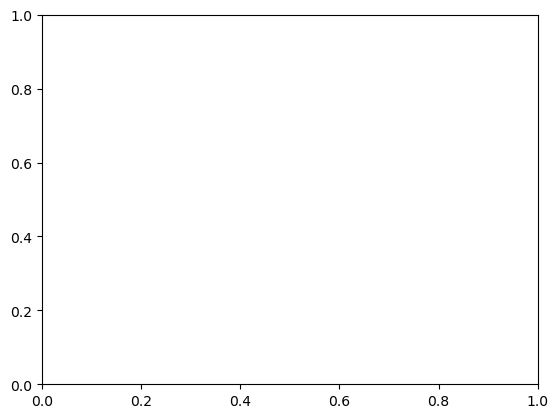

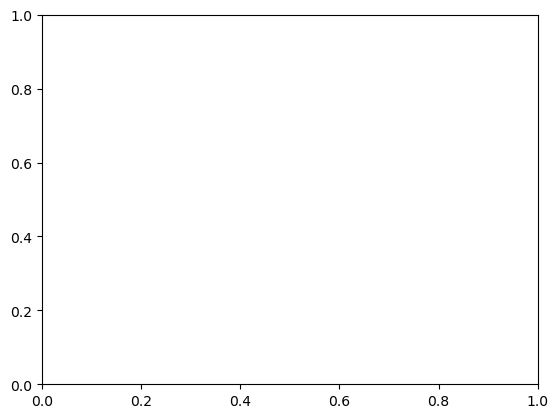

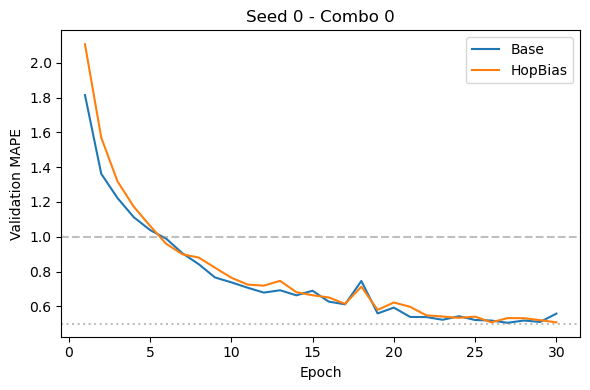

Seed=0, 조합 인덱스=1


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.3099, Valid Loss=1.2311, Train MAPE=1.4776, Valid MAPE=0.9675


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.0158, Valid Loss=1.0062, Train MAPE=1.1741, Valid MAPE=0.7150


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9450, Valid Loss=0.9317, Train MAPE=1.0283, Valid MAPE=0.6807


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.9019, Valid Loss=0.8773, Train MAPE=0.9362, Valid MAPE=0.6524


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8705, Valid Loss=0.8413, Train MAPE=0.8558, Valid MAPE=0.5381


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8393, Valid Loss=0.8128, Train MAPE=0.7841, Valid MAPE=0.4992


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.4340, Valid Loss=1.3490, Train MAPE=1.5033, Valid MAPE=0.9774


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.0215, Valid Loss=1.0186, Train MAPE=1.1982, Valid MAPE=0.7500


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9309, Valid Loss=0.9081, Train MAPE=1.0525, Valid MAPE=0.6020


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8916, Valid Loss=0.8782, Train MAPE=0.9571, Valid MAPE=0.6607


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8647, Valid Loss=0.8352, Train MAPE=0.8708, Valid MAPE=0.5094


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8395, Valid Loss=0.8124, Train MAPE=0.8075, Valid MAPE=0.5013


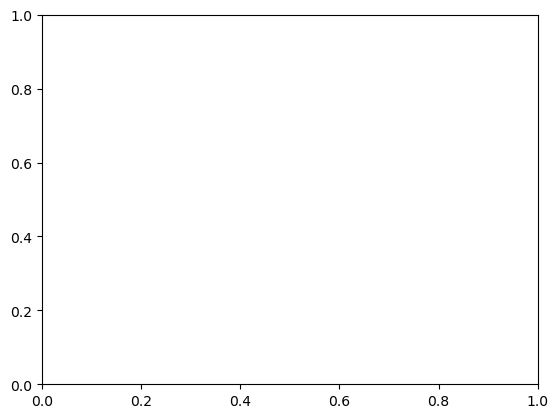

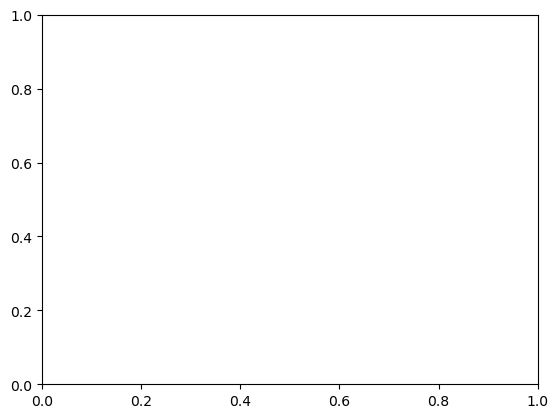

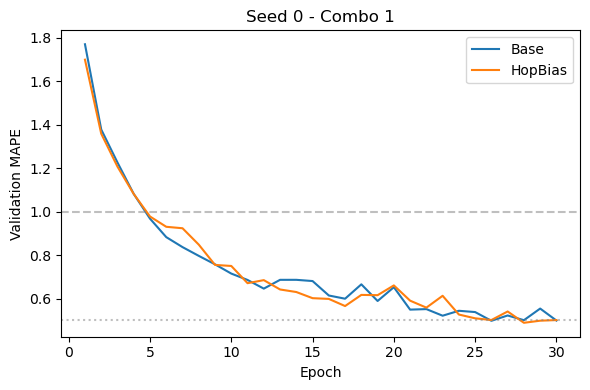

Seed=0, 조합 인덱스=2


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.2996, Valid Loss=1.2191, Train MAPE=1.5036, Valid MAPE=0.9532


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=0.9971, Valid Loss=0.9886, Train MAPE=1.1835, Valid MAPE=0.7000


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9352, Valid Loss=0.9126, Train MAPE=1.0300, Valid MAPE=0.6346


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8965, Valid Loss=0.8730, Train MAPE=0.9341, Valid MAPE=0.6752


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8679, Valid Loss=0.8425, Train MAPE=0.8567, Valid MAPE=0.5935


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8383, Valid Loss=0.8129, Train MAPE=0.7871, Valid MAPE=0.4887


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.4277, Valid Loss=1.3425, Train MAPE=1.5052, Valid MAPE=0.9740


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.0215, Valid Loss=1.0175, Train MAPE=1.2193, Valid MAPE=0.7653


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9337, Valid Loss=0.9069, Train MAPE=1.0628, Valid MAPE=0.6217


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8936, Valid Loss=0.8726, Train MAPE=0.9610, Valid MAPE=0.6719


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8646, Valid Loss=0.8333, Train MAPE=0.8691, Valid MAPE=0.5053


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8372, Valid Loss=0.8089, Train MAPE=0.8041, Valid MAPE=0.4924


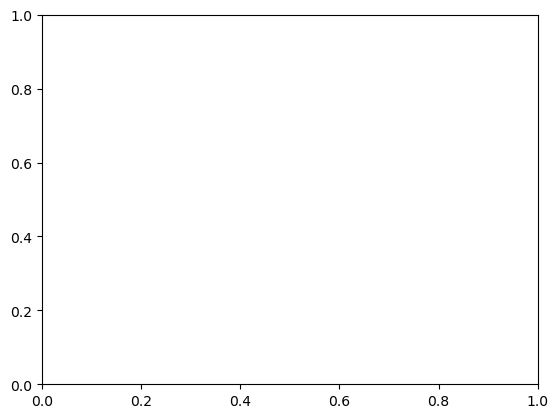

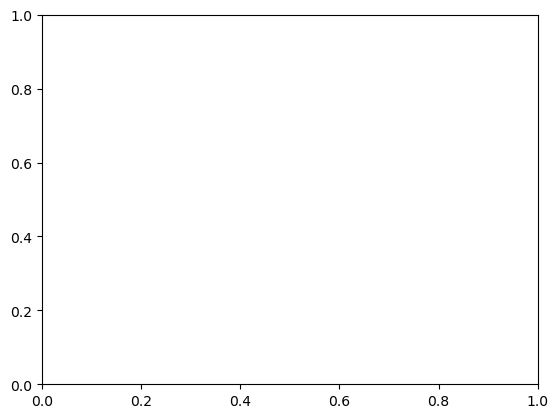

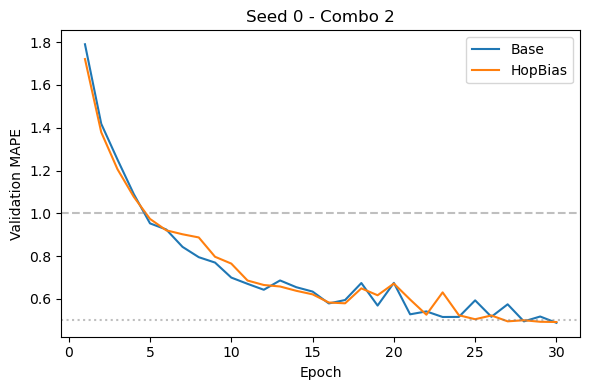

Seed=0, 조합 인덱스=3


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.2174, Valid Loss=1.1163, Train MAPE=1.6918, Valid MAPE=0.8679


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=0.9677, Valid Loss=0.9549, Train MAPE=1.3368, Valid MAPE=0.6304


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9182, Valid Loss=0.8858, Train MAPE=1.1650, Valid MAPE=0.5833


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8843, Valid Loss=0.8447, Train MAPE=1.0499, Valid MAPE=0.5428


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8573, Valid Loss=0.8214, Train MAPE=0.9371, Valid MAPE=0.6024


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8288, Valid Loss=0.7945, Train MAPE=0.8510, Valid MAPE=0.5059


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.2426, Valid Loss=1.1592, Train MAPE=1.6782, Valid MAPE=1.0009


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=0.9911, Valid Loss=0.9945, Train MAPE=1.3428, Valid MAPE=0.7200


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9387, Valid Loss=0.9150, Train MAPE=1.1690, Valid MAPE=0.6110


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8964, Valid Loss=0.8643, Train MAPE=1.0355, Valid MAPE=0.5610


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8655, Valid Loss=0.8357, Train MAPE=0.9242, Valid MAPE=0.5761


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8305, Valid Loss=0.7973, Train MAPE=0.8251, Valid MAPE=0.4993


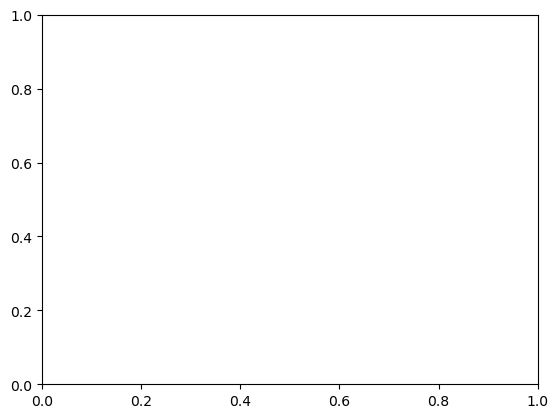

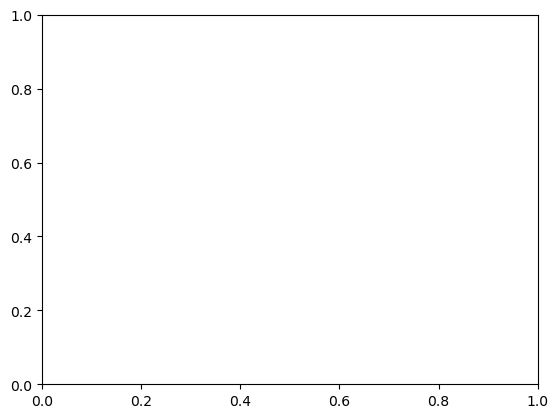

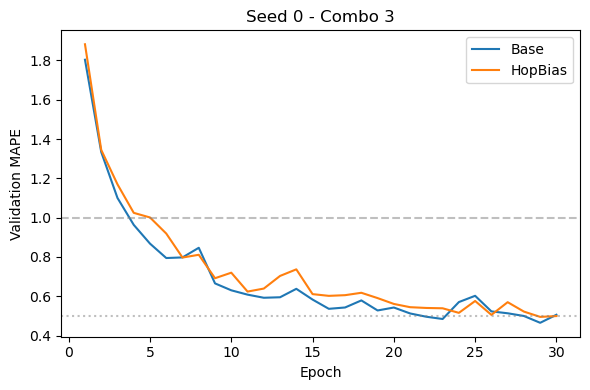

Seed=0, 조합 인덱스=4


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.3184, Valid Loss=1.2299, Train MAPE=1.5476, Valid MAPE=1.0384


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=0.9909, Valid Loss=0.9832, Train MAPE=1.2184, Valid MAPE=0.6987


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9238, Valid Loss=0.9136, Train MAPE=1.0676, Valid MAPE=0.6541


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8828, Valid Loss=0.8555, Train MAPE=0.9844, Valid MAPE=0.5462


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8467, Valid Loss=0.8241, Train MAPE=0.8932, Valid MAPE=0.5515


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8182, Valid Loss=0.7931, Train MAPE=0.8259, Valid MAPE=0.5013


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.2994, Valid Loss=1.2218, Train MAPE=1.4837, Valid MAPE=0.9446


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.0062, Valid Loss=0.9975, Train MAPE=1.2151, Valid MAPE=0.7210


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9331, Valid Loss=0.9116, Train MAPE=1.0772, Valid MAPE=0.6190


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8866, Valid Loss=0.8612, Train MAPE=0.9900, Valid MAPE=0.5958


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8502, Valid Loss=0.8244, Train MAPE=0.8995, Valid MAPE=0.5164


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8228, Valid Loss=0.7954, Train MAPE=0.8378, Valid MAPE=0.4940


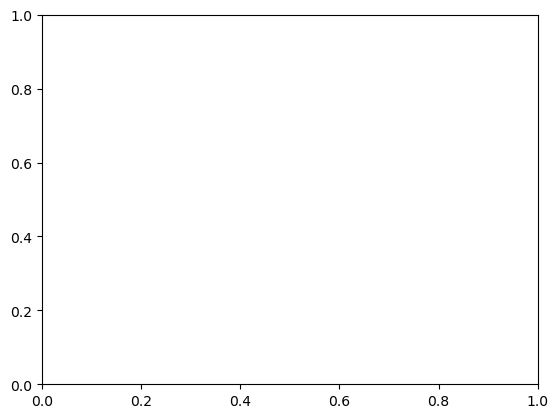

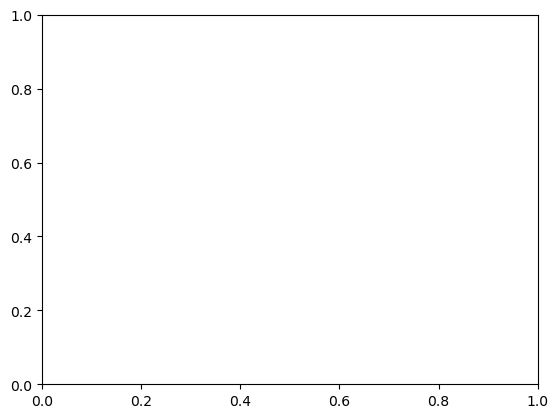

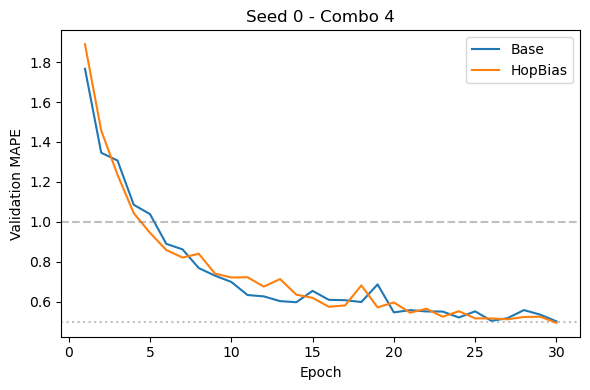

Seed=0, 조합 인덱스=5


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.3078, Valid Loss=1.2079, Train MAPE=1.6916, Valid MAPE=0.8905


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=0.9996, Valid Loss=0.9716, Train MAPE=1.3341, Valid MAPE=0.6653


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9267, Valid Loss=0.8987, Train MAPE=1.1342, Valid MAPE=0.6160


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8819, Valid Loss=0.8550, Train MAPE=1.0062, Valid MAPE=0.5993


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8493, Valid Loss=0.8197, Train MAPE=0.8823, Valid MAPE=0.5313


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8225, Valid Loss=0.7903, Train MAPE=0.7973, Valid MAPE=0.4958


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.3883, Valid Loss=1.2703, Train MAPE=1.8544, Valid MAPE=1.0174


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.0146, Valid Loss=0.9837, Train MAPE=1.4260, Valid MAPE=0.7328


Train 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 15] Train Loss=0.9347, Valid Loss=0.8970, Train MAPE=1.2063, Valid MAPE=0.5993


Train 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 20] Train Loss=0.8939, Valid Loss=0.8564, Train MAPE=1.0704, Valid MAPE=0.6106


Train 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 25] Train Loss=0.8606, Valid Loss=0.8225, Train MAPE=0.9442, Valid MAPE=0.4993


Train 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 30] Train Loss=0.8347, Valid Loss=0.7992, Train MAPE=0.8512, Valid MAPE=0.5234


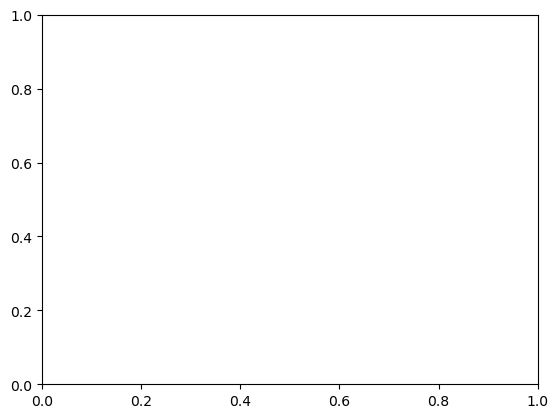

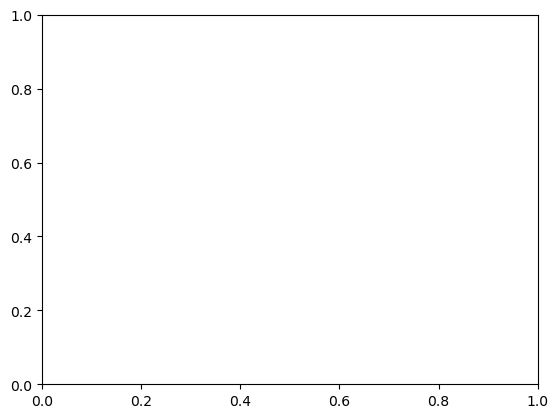

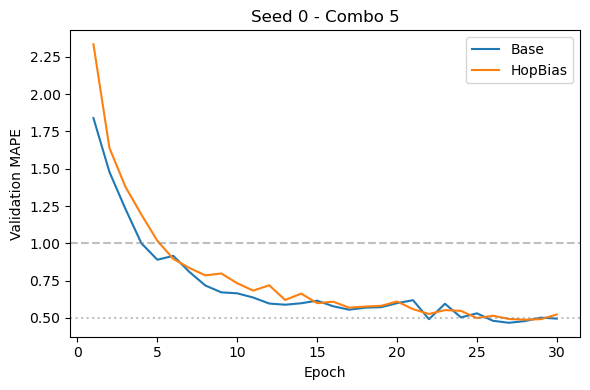

Seed=0, 조합 인덱스=6


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.3076, Valid Loss=1.2069, Train MAPE=1.7016, Valid MAPE=0.8819


Train 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/27 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/27 [00:00<?, ?it/s]

KeyboardInterrupt: 

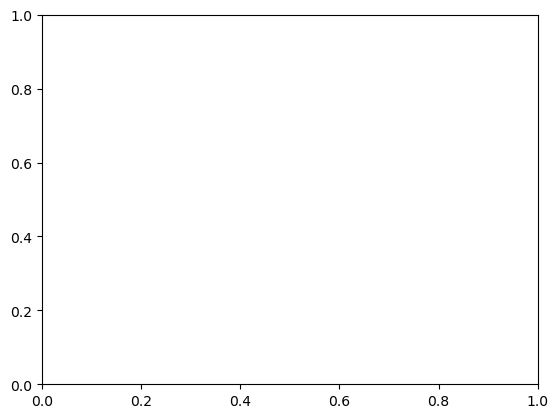

In [12]:
# %% [markdown]
# 4. 반복 실험: 16개의 시드를 사용해 학습 수행
#
# 결과를 기록할 리스트 초기화
results = []
# 시드 목록 (16개)
seeds = list(range(16))

# distance_hop_tensor 준비 (E, E)
# dataset_config.py에서 edge_spd를 가져왔으므로, numpy -> torch.LongTensor로 변환
from dataset.dataset_config import edge_spd
edge_spd_tensor = torch.from_numpy(edge_spd).long().to(DEVICE)

# 학습·평가 함수 정의

def train_and_evaluate(model, train_loader, val_loader, lr, weight_decay, epochs, seed):
    set_seed(seed)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.L1Loss()
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        device=DEVICE,
        print_interval=5,
        plot_interval=0
    )
    trainer.fit()
    history = trainer.get_history()
    return history

# 메인 루프
for seed in seeds:
    for idx, params in enumerate(selected_params):
        print(f"Seed={seed}, 조합 인덱스={idx}")
        # 모델 초기화
        model_base, model_hop = make_models(params, edge_spd_tensor)
        # 하이퍼파라미터: 학습률·감쇠 비율 (고정 혹은 params에 포함하면 추가)
        lr = 1e-4
        weight_decay = 1e-5
        epochs = 30
        
        # 4-1) Base 모델 학습
        history_base = train_and_evaluate(model_base, train_loader, valid_loader, lr, weight_decay, epochs, seed)
        # 4-2) Hop‑Biased 모델 학습
        history_hop  = train_and_evaluate(model_hop,  train_loader, valid_loader, lr, weight_decay, epochs, seed)

        # 4-3) 기록: history에서 valid MAPE, valid loss 추출
        val_mape_base = history_base['valid_mape']  # (length=epochs)
        val_loss_base = history_base['valid_loss']  # (length=epochs)
        val_mape_hop  = history_hop['valid_mape']
        val_loss_hop  = history_hop['valid_loss']

        # MAPE=1, 0.5 달성 에폭 찾기
        def first_epoch_leq(arr, threshold):
            for i, v in enumerate(arr):
                if v <= threshold:
                    return i + 1  # 1-based epoch
            return None

        mape1_epoch_base = first_epoch_leq(val_mape_base, 1.0)
        mape05_epoch_base = first_epoch_leq(val_mape_base, 0.5)
        min_mape_base = float(np.min(val_mape_base))
        min_loss_base = float(np.min(val_loss_base))

        mape1_epoch_hop = first_epoch_leq(val_mape_hop, 1.0)
        mape05_epoch_hop = first_epoch_leq(val_mape_hop, 0.5)
        min_mape_hop = float(np.min(val_mape_hop))
        min_loss_hop = float(np.min(val_loss_hop))

        # 4-4) 결과 저장
        results.append({
            'seed': seed,
            'combo_index': idx,
            'params': params,
            'mape1_epoch_base': mape1_epoch_base,
            'mape05_epoch_base': mape05_epoch_base,
            'min_mape_base': min_mape_base,
            'min_loss_base': min_loss_base,
            'mape1_epoch_hop': mape1_epoch_hop,
            'mape05_epoch_hop': mape05_epoch_hop,
            'min_mape_hop': min_mape_hop,
            'min_loss_hop': min_loss_hop,
            'history_base_mape': val_mape_base,
            'history_hop_mape': val_mape_hop,
        })
        
        # 4-5) 동적으로 검증 MAPE-에폭 그래프를 그리기
        # Base 모델 기록된 에폭 수
        epochs_base = len(val_mape_base)  # 예: 30이 아니라 15일 수도 있습니다.

        # HopBias 모델 기록된 에폭 수
        epochs_hop  = len(val_mape_hop)   # 예: 30이 아니라 20일 수도 있습니다.

        plt.figure(figsize=(6, 4))
        # Base 모델은 실제 기록 길이만큼, HopBias 모델도 마찬가지로 그립니다.
        plt.plot(range(1, epochs_base + 1), val_mape_base, label='Base')
        plt.plot(range(1, epochs_hop  + 1), val_mape_hop,  label='HopBias')

        plt.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
        plt.axhline(0.5, color='gray', linestyle=':',  alpha=0.5)
        plt.xlabel('Epoch')
        plt.ylabel('Validation MAPE')
        plt.title(f'Seed {seed} - Combo {idx}')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
# 5. 실험 결과 분석
df_results = pd.DataFrame(results)

# 예시: combo별로 평균 최저 MAPE 비교 (모델별)
agg_df = df_results.groupby('combo_index').agg({
    'min_mape_base': ['mean', 'std'],
    'min_mape_hop':  ['mean', 'std'],
    'mape1_epoch_base': ['mean', 'std'],
    'mape1_epoch_hop':  ['mean', 'std'],
})
print(agg_df)

# %% [markdown]
# 추가로, Hop‑Biased 모델의 개선 효과를 시각화할 수 있습니다.
# 예: combo별 (`combo_index`)로 Base 대비 HopBias가 몇 에폭 빠르게 MAPE=1을 달성했는지 등.

# (원하는 분석/시각화 코드를 여기에 추가)

# %% [markdown]
# 실험이 완료되었습니다.
